## CORONA ANALYSIS AND VISUALIZATION

This is visualization of the global Corona cases, recovered cases and deaths on various demographic levels. 
The notebook uses data from John Hopkins Repository for COVID cases. 

Note: This is a smaller version of the original file, as github does not load files with huge content

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import folium
import pycountry_convert as pc
import branca
import plotly.express as px
from datetime import datetime, timedelta, date
from scipy.interpolate import make_interp_spline, BSpline
import json, requests
import calmap
import seaborn as sns

from keras.layers import Input, Dense, Activation, LeakyReLU, Dropout
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Importing datasets

In [3]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [4]:
df_covid19 = df_covid19.drop(['People_Tested','People_Hospitalized','UID','ISO3','Mortality_Rate'],axis = 1)
df_covid19.head()

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate
0,Afghanistan,2020-08-20 06:27:44,33.93911,67.709953,37599.0,1375.0,27166.0,9058.0,96.585159
1,Albania,2020-08-20 06:27:44,41.15330,20.168300,7812.0,234.0,3928.0,3650.0,271.457363
2,Algeria,2020-08-20 06:27:44,28.03390,1.659600,39847.0,1402.0,27971.0,10474.0,90.868990
3,Andorra,2020-08-20 06:27:44,42.50630,1.521800,1024.0,53.0,875.0,96.0,1325.309001
4,Angola,2020-08-20 06:27:44,-11.20270,17.873900,2015.0,92.0,698.0,1225.0,6.130906


In [5]:
df_confirmed.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,37162,37269,37345,37424,37431,37551,37596,37599,37599,37599
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,6536,6676,6817,6971,7117,7260,7380,7499,7654,7812


In [6]:
df_confirmed = df_confirmed.rename(columns = {'Province/State':'state','Country/Region':'country'})
df_deaths = df_deaths.rename(columns = {'Province/State':'state','Country/Region':'country'})
df_covid19 = df_covid19.rename(columns = {'Country_Region':'country'})
df_covid19['Active'] = df_covid19['Confirmed'] - df_covid19['Recovered'] - df_covid19['Deaths']

In [7]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'


countries = np.asarray(df_confirmed['country'])

continents = {
    'NA':'North America',
    'SA':'South America',
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except:
        return 'na'
    
df_confirmed.insert(2, 'continent',[continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2, 'continent',[continents[country_to_continent_code(country)] for country in countries[:]])
countries1 = np.asarray(df_covid19['country'])

df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1, 'continent',[continents[country_to_continent_code(country)] for country in df_table['Country_Region'].values])



In [8]:
df_confirmed = df_confirmed.replace(np.nan, '', regex = True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

In [9]:
df_confirmed['continent'].value_counts()

Asia             76
Europe           69
Africa           54
North America    36
South America    12
Australia        11
Others            8
Name: continent, dtype: int64

### Defining Functions

In [10]:
def plot_params(ax, axis_label = None, plt_title = None, label_size=15, axis_fsize = 15, title_fsize = 15, scale = 'linear'):
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which = 'both', width = 1, labelsize = label_size)
    ax.tick_params(which = 'major', length = 6)
    ax.tick_params(which = 'minor', length = 3, color = '0.8')
    
    #grid
    plt.grid(lw = 1, ls = '-', c = '0.7', which = 'major')
    plt.grid(lw = 1, ls = '-', c = '0.9', which = 'minor')
    
    #Plot Title
    plt.title(plt_title, {'fontsize':title_fsize})
    
    #yaxis scale
    plt.yscale(scale)
    plt.minorticks_on()
    x1 = plt.xlabel(axis_label[0], fontsize = axis_fsize)
    y1 = plt.ylabel(axis_label[1], fontsize=axis_fsize)
    

def visualize_covid_cases(confirmed, deaths, continent = None, country = None, state = None, period = None, figure = None, scale = 'linear'):
    x = 0
    if figure == None:
        f = plt.figure(figsize = (10,10))
        ax = f.add_subplot(111)
    else:
        f = figure[0]
        #sub plot
        ax = f.add_subplot(figure[1], figure[2], figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad = 10, w_pad = 5, h_pad = 5)

    stats = [confirmed, deaths]
    label = ['Confirmed', 'Deaths']
    
    if continent != None:
        params = ['continent', continent]
    elif country != None:
        params = ['country', country]
    else: 
        params = ['All', 'All']
        
    color = ['darkcyan', 'crimson']
    marker_style = dict(linewidth = 3, linestyle = '-', marker = 'o', markersize = 4, markerfacecolor = '#ffffff')
    
    for i, stat in enumerate(stats):
        if params[1] == 'All':
            cases = np.sum(np.asarray(stat.iloc[:,5:]), axis = 0)[x:]
        else: 
            cases = np.sum(np.asarray(stat[stat[params[0]] ==params[1]].iloc[:,5:]), axis =0)[x:]
        date = np.arange(1, cases.shape[0]+1)[x:]
        plt.plot(date, cases, label = label[i]+ ' (Total : '+str(cases[-1])+')', color = color[i], **marker_style)
        plt.fill_between(date, cases, color = color[i], alpha = 0.3)
        
    if params[1] == 'All':
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:, 5:]), axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:, 5:]), axis = 0)[x:]
    else: 
        Total_confirmed = np.sum(np.asarray(stats[0][stat[params[0]]==params[1]].iloc[:,5:]), axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]]==params[1]].iloc[:,5:]), axis = 0)[x:]
        
    text = 'From '+stats[0].columns[5]+' to '+stats[0].columns[-1]+'\n'
    text += 'Mortality rate : '+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100) + '\n'
    text += 'Last 5 Days:\n'
    text += 'Confirmed : ' + str(Total_confirmed[-1] - Total_confirmed[-6]) + '\n'
    text += 'Deaths : ' + str(Total_deaths[-1] - Total_deaths[-6]) + '\n'
    text += 'Last 24 Hours: \n'
    text += 'Confirmed : '+str(Total_confirmed[-1] - Total_confirmed[-2]) + '\n'
    text += 'Deaths : ' + str(Total_deaths[-1] - Total_deaths[-2]) + '\n'
    
    plt.text(0.02, 0.78, text, fontsize = 15, horizontalalignment = 'left', verticalalignment = 'top', transform= ax.transAxes, 
             bbox= dict(facecolor = 'white', alpha =0.4))
    #plot axes labels
    axis_label = ['Days ('+df_confirmed.columns[5]+' - '+df_confirmed.columns[-1]+')','No of Cases']
    
    #plot parameters
    plot_params(ax, axis_label, scale = scale)
    
    #plot title
    if params[1] == 'All':
        plt.title('Covid-19 Cases World', {'fontsize': 25})
    else:
        plt.title('Covid-19:'+ params[1], {'fontsize':25})
        
    #legend Location
    
    l = plt.legend(loc = 'best', fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = 'All'):
    if(country == 'All'):
        return np.sum(np.asarray(cases.iloc[:,5:]), axis = 0)[-1]
    else:
        return np.sum(np.asarray(cases[cases['country']==country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed, deaths, continent = None, country = None):
    if continent != None:
        params = ['continent',continent]
    elif country != None:
        params = ['country', country]
    else: 
        params = ['All','All']
        
    if params[1] == 'All':
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:, 5:]), axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]), axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100, 2)
        
    else: 
        Total_confirmed = np.sum(np.asarray(confirmed[confirmed[params[0]]== params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]]==params[1]].iloc[:, 5:]), axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100, 2)
        
    return np.nan_to_num(mortality_rate)

def dd(date1, date2):
    return (datetime.strptime(date1, '%m/%d/%y') - datetime.strptime(date2, '%m/%d/%y')).days

out = ''

### Analysis of Data

In [11]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_', 'continent', 'Last_Update'],axis = 1)
df_countries_cases.index = df_countries_cases['country']
df_countries_cases = df_countries_cases.drop(['country'],axis = 1)

df_continents_cases = df_covid19.copy().drop(['Lat', 'Long_','country','Last_Update'],axis = 1)
df_continents_cases = df_continents_cases.groupby(['continent']).sum()

df_countries_cases.fillna(0, inplace=True)


In [12]:
df_continents_cases = df_covid19.copy().drop(['Lat', 'Long_','country','Last_Update'],axis = 1)
df_continents_cases = df_continents_cases.groupby(['continent']).sum()

df_countries_cases.fillna(0, inplace=True)


In [13]:
df_countries_cases

,Confirmed,Deaths,Recovered,Active,Incident_Rate
country,,,,,
Afghanistan,37599.0,1375.0,27166.0,9058.0,96.585159
Albania,7812.0,234.0,3928.0,3650.0,271.457363
Algeria,39847.0,1402.0,27971.0,10474.0,90.868990
Andorra,1024.0,53.0,875.0,96.0,1325.309001
Angola,2015.0,92.0,698.0,1225.0,6.130906
...,...,...,...,...,...
West Bank and Gaza,17606.0,119.0,10312.0,7175.0,345.119865
Western Sahara,10.0,1.0,8.0,1.0,1.674116
Yemen,1892.0,539.0,1055.0,298.0,6.343466


In [14]:
#Global Reported Cases Till Date

df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype = np.float64).transpose()
df_t['Mortality Rate (per 100)'] = np.round(100*df_t['Deaths']/df_t['Confirmed'],2)
df_t.style.background_gradient(cmap='Wistia',axis = 1).format('{:.2f}').format("{:.0f}",subset=['Confirmed','Deaths','Recovered','Active'])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
0,22412859,787701,14338849,7177329,66556.54,3.51


In [15]:
df_continents_cases.head()

,Confirmed,Deaths,Recovered,Active,Incident_Rate
continent,,,,,
Africa,1147622.0,26640.0,870459.0,250523.0,6044.697931
Asia,5914236.0,124698.0,4625690.0,1163848.0,20883.769680
Australia,26265.0,489.0,19513.0,6263.0,136.494878
Europe,3264832.0,204130.0,1857778.0,1093951.0,19414.605098
North America,6555654.0,249600.0,2684957.0,3621097.0,8114.075679


### Continent wise reporting

In [16]:
df_continents_cases["Mortality Rate (per 100)"] = np.round(100*df_continents_cases["Deaths"]/df_continents_cases["Confirmed"],2)

In [17]:

df_continents_cases.style.background_gradient(cmap='Blues', subset=['Confirmed'])\
.background_gradient(cmap='Reds', subset=['Deaths'])\
.background_gradient(cmap= 'Greens', subset = ['Recovered'])\
.background_gradient(cmap = 'Purples', subset=['Active'])\
.background_gradient(cmap = 'Pastel1_r', subset=['Incident_Rate'])\
.background_gradient(cmap = 'YlOrBr', subset = ['Mortality Rate (per 100)'])\
.format('{:.2f}')\
.format('{:.0f}', subset=['Confirmed', 'Deaths', 'Recovered','Active'])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
continent,,,,,,
Africa,1147622,26640,870459,250523,6044.70,2.32
Asia,5914236,124698,4625690,1163848,20883.77,2.11
Australia,26265,489,19513,6263,136.49,1.86
Europe,3264832,204130,1857778,1093951,19414.61,6.25
North America,6555654,249600,2684957,3621097,8114.08,3.81
Others,30313,531,18684,11091,2470.44,1.75
South America,5473937,181613,4261768,1030556,9492.45,3.32


### Country Wise Reported Cases

In [18]:
df_countries_cases['Mortality Rate (per 100)'] = np.round(100*df_countries_cases['Confirmed']/df_countries_cases['Deaths'],2)
df_countries_cases.sort_values('Confirmed',ascending = False).head().style.background_gradient(cmap = 'Blues', subset=['Confirmed'])\
.background_gradient(cmap='Reds',subset=["Deaths"])\
.background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='Purples',subset=["Active"])\
.background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
.background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\
.format("{:.2f}")\
.format("{:.0f}",subset=["Confirmed","Deaths","Recovered","Active"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
country,,,,,,
USA,5529933,173181,1925049,3431703,1678.45,3193.15
Brazil,3456652,111100,2801931,543621,1626.21,3111.30
India,2836925,53866,2096664,686395,205.57,5266.63
Russia,935066,15951,747802,171313,640.74,5862.12
South Africa,596060,12423,491441,92196,1005.01,4798.04


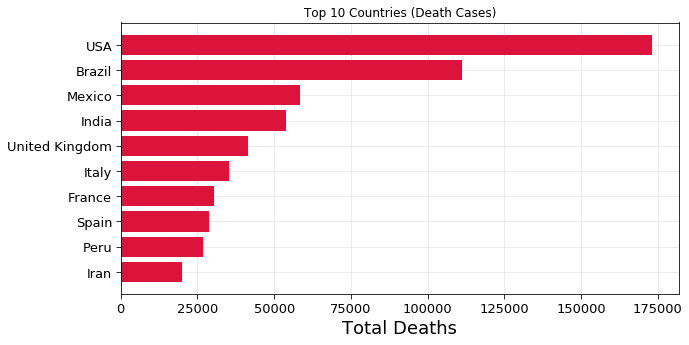

In [19]:
f = plt.figure(figsize = (10,5))
f.add_subplot(111)

plt.axes(axisbelow = True)
plt.barh(df_countries_cases.sort_values('Deaths')['Deaths'].index[-10:], 
         df_countries_cases.sort_values('Deaths')['Deaths'].values[-10:],color = 'crimson')
plt.tick_params(size = 5, labelsize = 13)
plt.xlabel('Total Deaths', fontsize = 18)
plt.title('Top 10 Countries (Death Cases)')
plt.grid(alpha = 0.3, which = 'both')

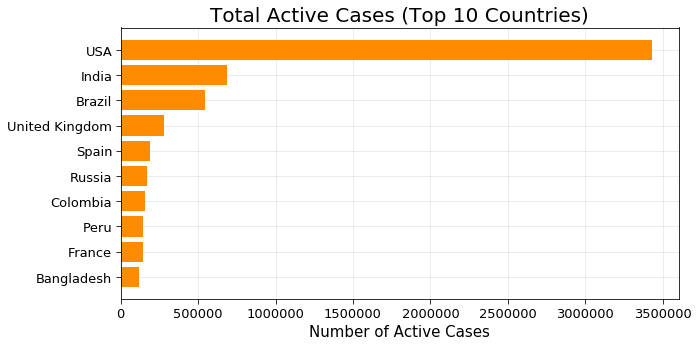

In [20]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')['Active'].index[-10:],
         df_countries_cases.sort_values('Active')['Active'].values[-10:], color= 'darkorange')
plt.tick_params(size =5, labelsize = 13)
plt.xlabel('Number of Active Cases', fontsize = 15)
plt.title('Total Active Cases (Top 10 Countries)', fontsize = 20)
plt.grid(alpha = 0.3, which = 'both')

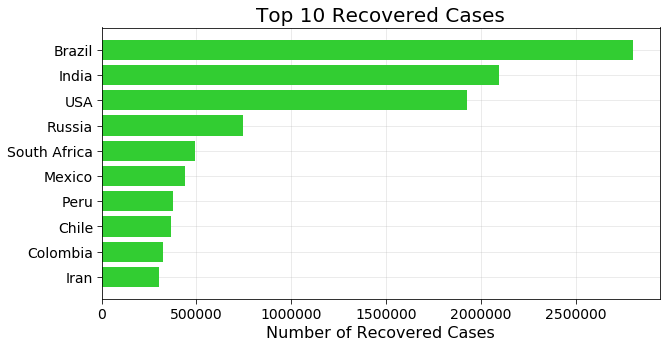

In [21]:
f = plt.figure(figsize = (10,5))
f.add_subplot(111)

plt.axes(axisbelow = True)
plt.barh(df_countries_cases.sort_values('Recovered')['Recovered'].index[-10:], 
         df_countries_cases.sort_values('Recovered')['Recovered'].values[-10:], color = 'limegreen' )
plt.tick_params(size = 5, labelsize= 14)
plt.xlabel('Number of Recovered Cases',fontsize=16)
plt.title('Top 10 Recovered Cases', fontsize = 20)
plt.grid(alpha = 0.3, which = 'both')

In [22]:
df_countries_cases.corr().style.background_gradient(cmap = 'Reds').format('{:.3f}')

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
Confirmed,1.000,0.941,0.921,0.895,0.281,-0.043
Deaths,0.941,1.000,0.842,0.862,0.277,-0.077
Recovered,0.921,0.842,1.000,0.651,0.284,-0.038
Active,0.895,0.862,0.651,1.000,0.219,-0.038
Incident_Rate,0.281,0.277,0.284,0.219,1.000,0.212
Mortality Rate (per 100),-0.043,-0.077,-0.038,-0.038,0.212,1.000


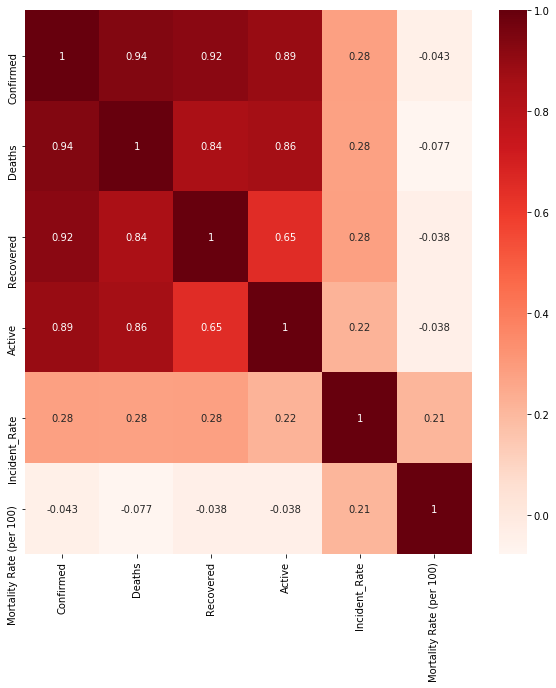

In [23]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_countries_cases.corr(), annot = True, cmap = 'Reds')
plt.show()

In [24]:
world_map = folium.Map(location = [10,0], tiles = 'cartodbpositron', zoom_start = 2, max_zoom = 6, min_zoom = 2)

for i in range(0, len(df_confirmed)):
    folium.Circle(
        location = [df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style = 'text-align: center; font-weight: bold'>"+df_confirmed.iloc[i]['country']+'</h5>'+
        "<div style ='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
        "<hr style = 'margin:10px;'>"+
        "<ul style = 'color:#444; list-style:circle; aling-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths: "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate: "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius = (int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color = '#ff6600',
        fill_color = '#ff8533',
        fill = True).add_to(world_map)
    
world_map

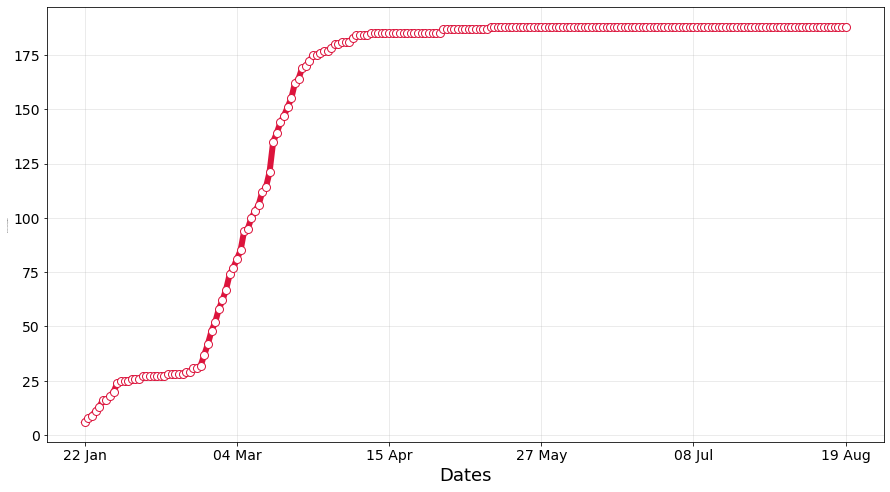

In [31]:
case_nums_country = df_confirmed.groupby('country').sum().drop(['Lat','Long'], axis =1).apply(lambda x: x[x>0].count(), axis =0)
d = [datetime.strptime(date, '%m/%d/%y').strftime('%d %b') for date in case_nums_country.index]

f = plt.figure(figsize = (15,8))
f.add_subplot(111)
marker_style = dict(c = 'crimson', linewidth = 6, linestyle = '-', marker = 'o', markersize = 8, markerfacecolor= '#ffffff')
plt.plot(d, case_nums_country, **marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0, len(d), int(len(d)/5))), d[:-1:int(len(d)/5)]+[d[-1]])

plt.xlabel('Dates', fontsize = 18)
plt.ylabel('Number of Countries/Regions', fontsize = 1)
plt.grid(alpha = 0.3)
plt.show()

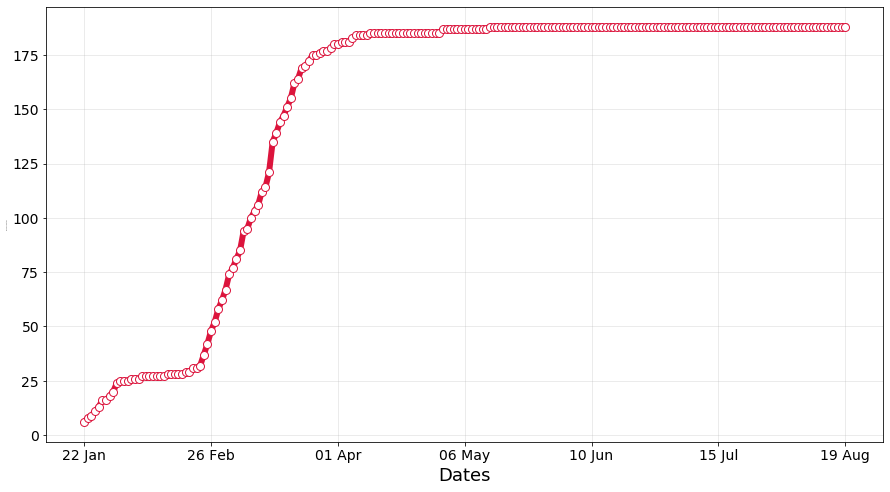

In [32]:
case_nums_country = df_confirmed.groupby('country').sum().drop(['Lat','Long'], axis = 1).apply(lambda x: x[x>0].count(), axis = 0)
d = [datetime.strptime(date, '%m/%d/%y').strftime('%d %b') for date in case_nums_country.index]

f = plt.figure(figsize = (15,8))
f.add_subplot(111)
marker_style = dict(c = 'crimson', linewidth = 6, linestyle = '-', marker= 'o', markersize = 8, markerfacecolor = '#ffffff')
plt.plot(d, case_nums_country, **marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0, len(d), int(len(d)/6))),d[:-1:int(len(d)/6)]+[d[-1]])

plt.xlabel('Dates',fontsize = 18)
plt.ylabel('Number of Countries', fontsize = 1)
plt.grid(alpha = 0.3)
plt.show()

### COVID SPREAD ANALYSIS

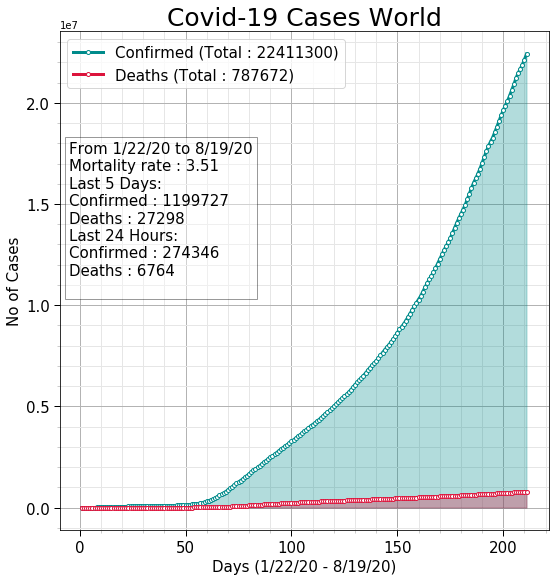

In [33]:
cols = 1
rows = 1
f = plt.figure(figsize = (10,10*rows))

visualize_covid_cases(df_confirmed, df_deaths, continent = 'All', figure= [f, rows, cols, 1])
plt.show()

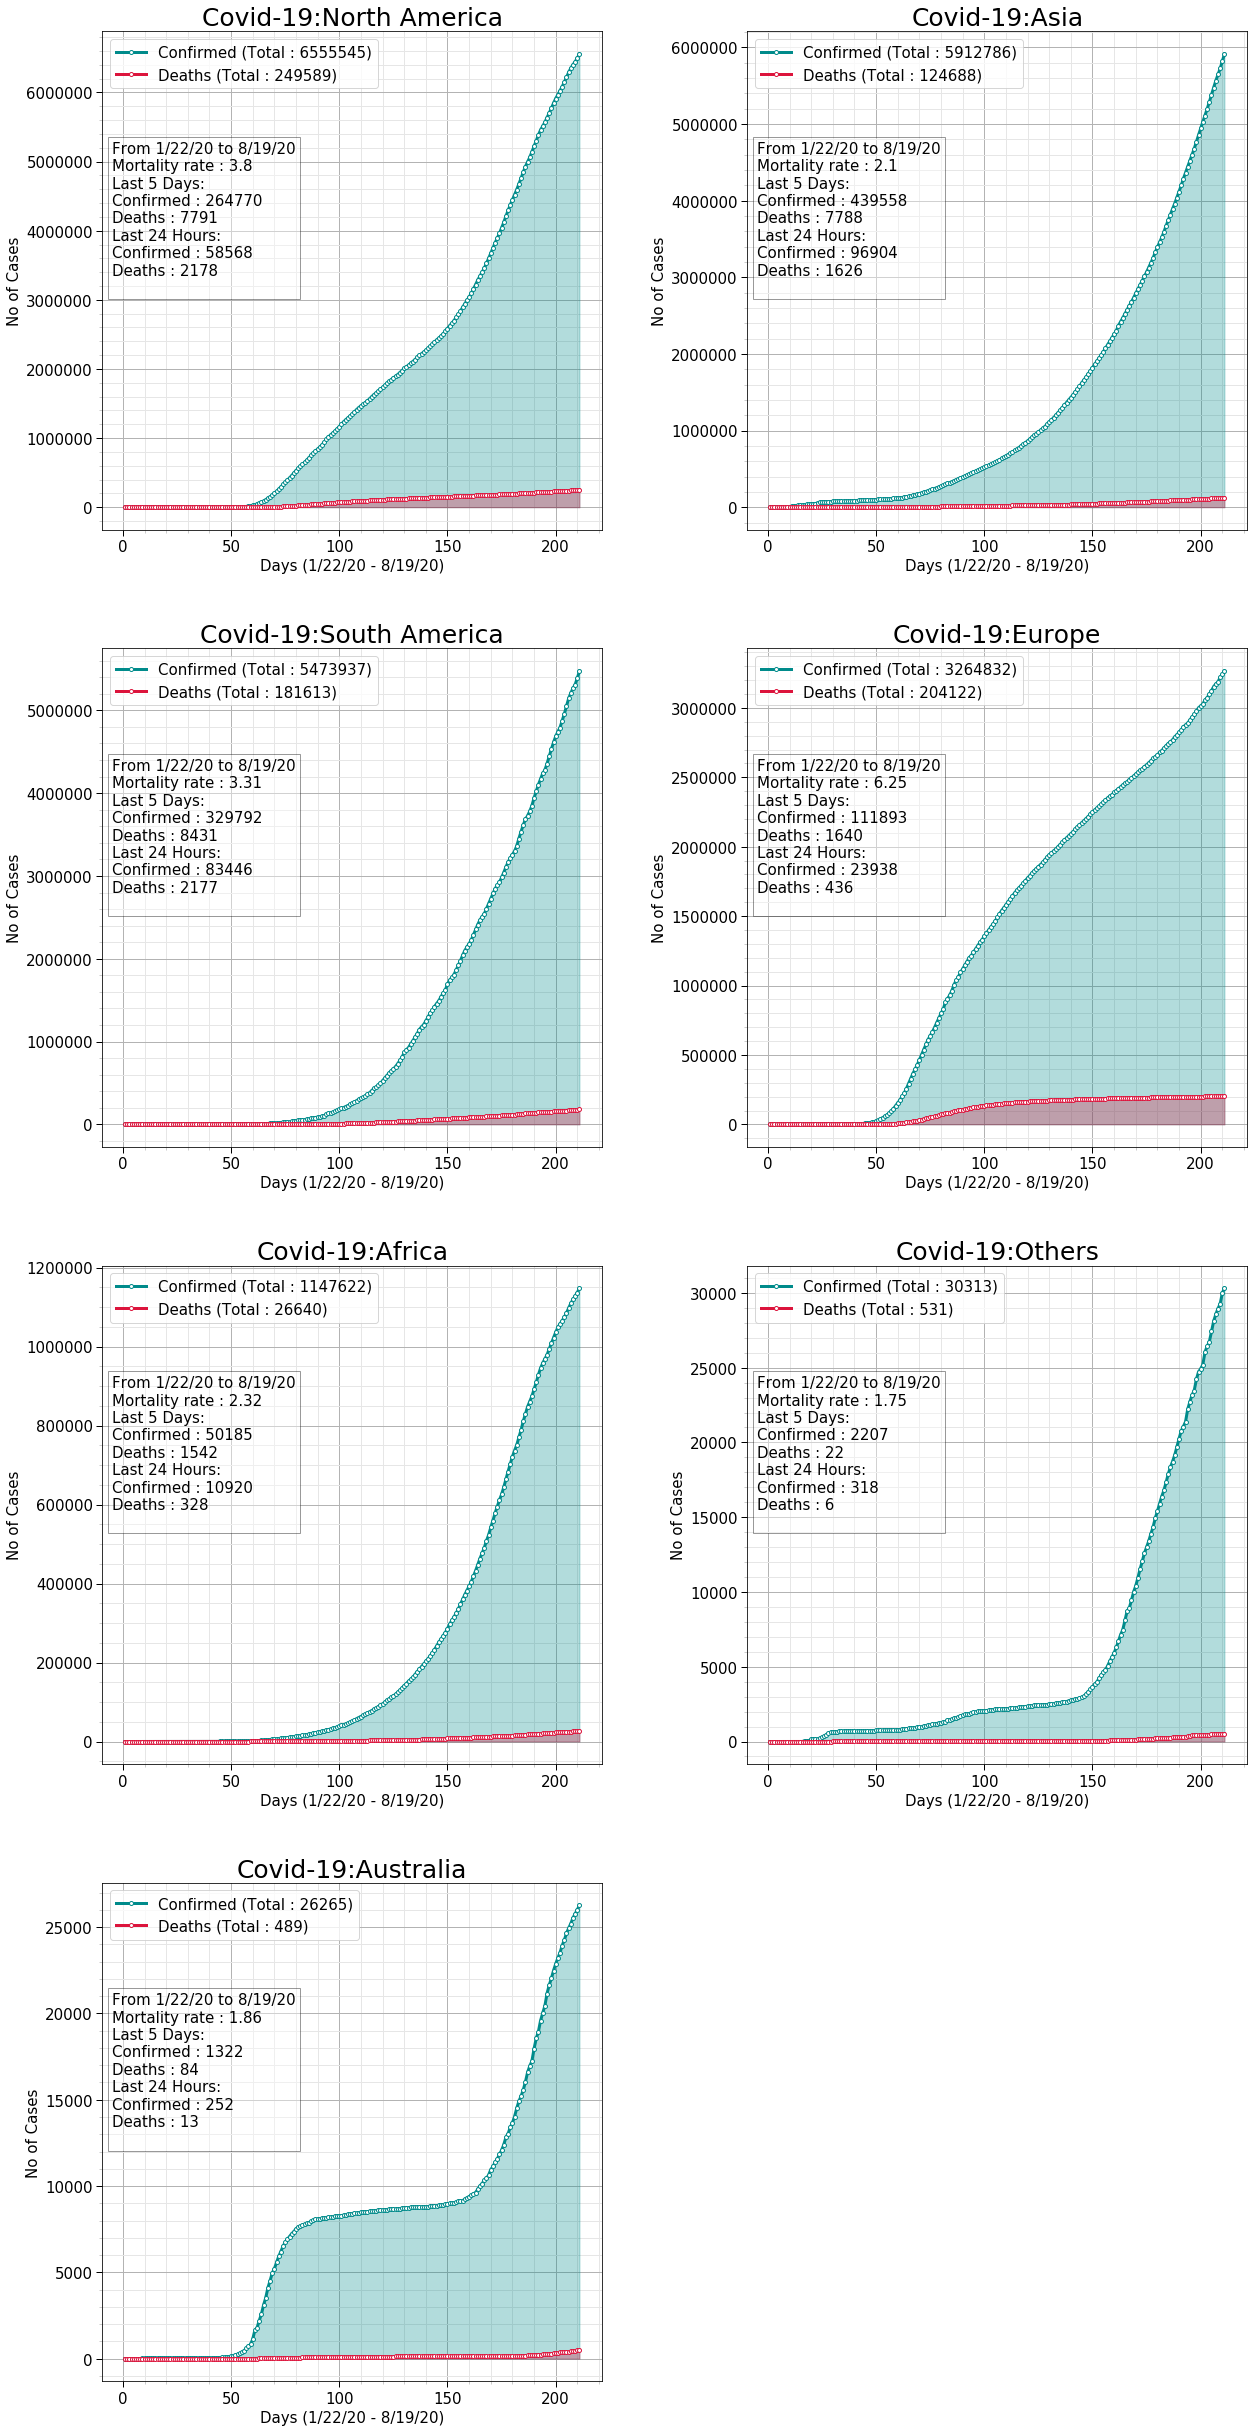

In [34]:
df_continents = df_confirmed.groupby(['continent']).sum()
continents = df_continents.sort_values(df_continents.columns[-1],ascending = False).index

cols = 2
rows = int(np.ceil(continents.shape[0]/cols))
f = plt.figure(figsize = (20, 9*rows))
for i, continent in enumerate(continents):
    visualize_covid_cases(df_confirmed, df_deaths, continent = continent, figure = [f, rows, cols, i+1])
    
plt.show()